In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

!pip install chart_studio
#from plotly import plotly
#import plotly.offline as offline
#import plotly.graph_objs as go

import chart_studio.plotly as py
import plotly.graph_objs as go
from collections import Counter


     |████████████████████████████████| 71kB 3.3MB/s 


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# load dataset 
project_data = pd.read_csv("/content/drive/MyDrive/collab_data/donorchoose/train_data.csv")
resource_data = pd.read_csv("/content/drive/MyDrive/collab_data/donorchoose/resources.csv")

In [5]:
print("Number of data points in the train dataset: ", project_data.shape)
print("-"*80)
print("Attributes of dataset: ", project_data.columns.values)

Number of data points in the train dataset:  (109248, 17)
--------------------------------------------------------------------------------
Attributes of dataset:  ['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']


In [6]:
print("Number of data points in resource data: ", resource_data.shape)
print("-"*80)
print("Attributes of dataset: ", resource_data.columns.values)

Number of data points in resource data:  (1541272, 4)
--------------------------------------------------------------------------------
Attributes of dataset:  ['id' 'description' 'quantity' 'price']


In [7]:
resource_data.head(2)

,id,description,quantity,price
0,p233245,LC652 - Lakeshore Double-Space Mobile Drying Rack,1,149.00
1,p069063,Bouncy Bands for Desks (Blue support pipes),3,14.95


In [8]:
project_data.head(2)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,Grades PreK-2,Literacy & Language,"ESL, Literacy",Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,2016-10-25 09:22:10,Grades 6-8,"History & Civics, Health & Sports","Civics & Government, Team Sports",Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1


In [9]:
y_value_count = project_data['project_is_approved'].value_counts()
print(y_value_count)

1    92706
0    16542
Name: project_is_approved, dtype: int64


In [10]:
print("Number of projects approved: ", y_value_count[1], "|", y_value_count[1]/(y_value_count[0]+y_value_count[1]) * 100, "%" )
print("Number of projects not approved: ", y_value_count[0], "|", y_value_count[0]/(y_value_count[0]+y_value_count[1]) * 100, "%" )

Number of projects approved:  92706 | 84.85830404217927 %
Number of projects not approved:  16542 | 15.141695957820739 %


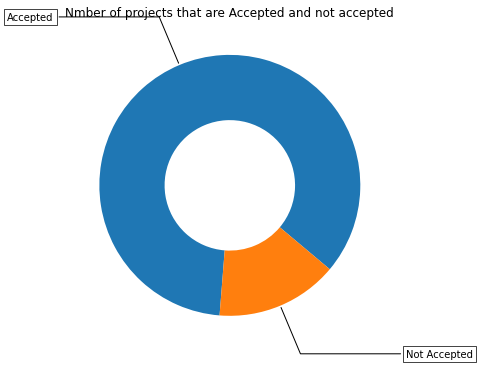

In [11]:
# pie chart

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(aspect="equal"))
recipe = ["Accepted", "Not Accepted"]

data = [y_value_count[1], y_value_count[0]]

wedges, texts = ax.pie(data, wedgeprops=dict(width=0.5), startangle=-40)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(recipe[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                 horizontalalignment=horizontalalignment, **kw)

ax.set_title("Nmber of projects that are Accepted and not accepted")

plt.show()

In [12]:
# https://www.csi.cuny.edu/sites/default/files/pdf/administration/ops/2letterstabbrev.pdf

temp = pd.DataFrame(project_data.groupby("school_state")["project_is_approved"].apply(np.mean)).reset_index()
# if you have data which contain only 0 and 1, then the mean = percentage (think about it)
temp.columns = ['state_code', 'num_proposals']

temp.sort_values(by=['num_proposals'], inplace=True)
print("States with lowest % approvals")
print(temp.head(5))
print('='*50)
print("States with highest % approvals")
print(temp.tail(5))

States with lowest % approvals
   state_code  num_proposals
46         VT       0.800000
7          DC       0.802326
43         TX       0.813142
26         MT       0.816327
18         LA       0.831245
States with highest % approvals
   state_code  num_proposals
30         NH       0.873563
35         OH       0.875152
47         WA       0.876178
28         ND       0.888112
8          DE       0.897959


In [13]:
np.arange(project_data.shape[0])

array([     0,      1,      2, ..., 109245, 109246, 109247])

In [14]:
temp = pd.DataFrame(project_data.groupby('school_state')['project_is_approved'].agg(lambda x: x.eq(1).sum())).reset_index()

In [15]:
print(temp)
col1 = 'school_state'
col2 = 'project_is_approved'

   school_state  project_is_approved
0            AK                  290
1            AL                 1506
2            AR                  872
3            AZ                 1800
4            CA                13205
5            CO                  935
6            CT                 1445
7            DC                  414
8            DE                  308
9            FL                 5144
10           GA                 3329
11           HI                  434
12           IA                  568
13           ID                  579
14           IL                 3710
15           IN                 2214
16           KS                  532
17           KY                 1126
18           LA                 1990
19           MA                 2055
20           MD                 1270
21           ME                  428
22           MI                 2672
23           MN                 1036
24           MO                 2202
25           MS                 1118
2

In [16]:
temp['total'] = pd.DataFrame(project_data.groupby(col1)[col2].agg(total='count')).reset_index()['total']
temp['Avg'] = pd.DataFrame(project_data.groupby(col1)[col2].agg(Avg='mean')).reset_index()['Avg']

In [17]:
print(temp)

   school_state  project_is_approved  total       Avg
0            AK                  290    345  0.840580
1            AL                 1506   1762  0.854711
2            AR                  872   1049  0.831268
3            AZ                 1800   2147  0.838379
4            CA                13205  15388  0.858136
5            CO                  935   1111  0.841584
6            CT                 1445   1663  0.868912
7            DC                  414    516  0.802326
8            DE                  308    343  0.897959
9            FL                 5144   6185  0.831690
10           GA                 3329   3963  0.840020
11           HI                  434    507  0.856016
12           IA                  568    666  0.852853
13           ID                  579    693  0.835498
14           IL                 3710   4350  0.852874
15           IN                 2214   2620  0.845038
16           KS                  532    634  0.839117
17           KY             

In [18]:
temp.sort_values(by=['total'],inplace=True, ascending=False)
print(temp)

   school_state  project_is_approved  total       Avg
4            CA                13205  15388  0.858136
43           TX                 6014   7396  0.813142
34           NY                 6291   7318  0.859661
9            FL                 5144   6185  0.831690
27           NC                 4353   5091  0.855038
14           IL                 3710   4350  0.852874
10           GA                 3329   3963  0.840020
40           SC                 3385   3936  0.860010
22           MI                 2672   3161  0.845302
38           PA                 2658   3109  0.854937
15           IN                 2214   2620  0.845038
24           MO                 2202   2576  0.854814
35           OH                 2159   2467  0.875152
18           LA                 1990   2394  0.831245
19           MA                 2055   2389  0.860193
47           WA                 2045   2334  0.876178
36           OK                 1900   2276  0.834798
31           NJ             

In [19]:
#stacked bar plots matplotlib: https://matplotlib.org/gallery/lines_bars_and_markers/bar_stacked.html
def stack_plot(data, xtick, col2='project_is_approved', col3='total'):
    ind = np.arange(data.shape[0])
    
    plt.figure(figsize=(20,5))
    p1 = plt.bar(ind, data[col3].values)
    p2 = plt.bar(ind, data[col2].values)

    plt.ylabel('Projects')
    plt.title('% of projects aproved state wise')
    plt.xticks(ind, list(data[xtick].values))
    plt.legend((p1[0], p2[0]), ('total', 'accepted'))
    plt.show()

def univariate_barplots(data, col1, col2='project_is_approved', top=False):
    # Count number of zeros in dataframe python: https://stackoverflow.com/a/51540521/4084039
    temp = pd.DataFrame(project_data.groupby(col1)[col2].agg(lambda x: x.eq(1).sum())).reset_index()

    # Pandas dataframe grouby count: https://stackoverflow.com/a/19385591/4084039
    temp['total'] = pd.DataFrame(project_data.groupby(col1)[col2].agg(total='count')).reset_index()['total']
    temp['Avg'] = pd.DataFrame(project_data.groupby(col1)[col2].agg(Avg='mean')).reset_index()['Avg']
    
    temp.sort_values(by=['total'],inplace=True, ascending=False)
    
    if top:
        temp = temp[0:top]
    
    stack_plot(temp, xtick=col1, col2=col2, col3='total')
    print(temp.head(5))
    print("="*50)
    print(temp.tail(5))

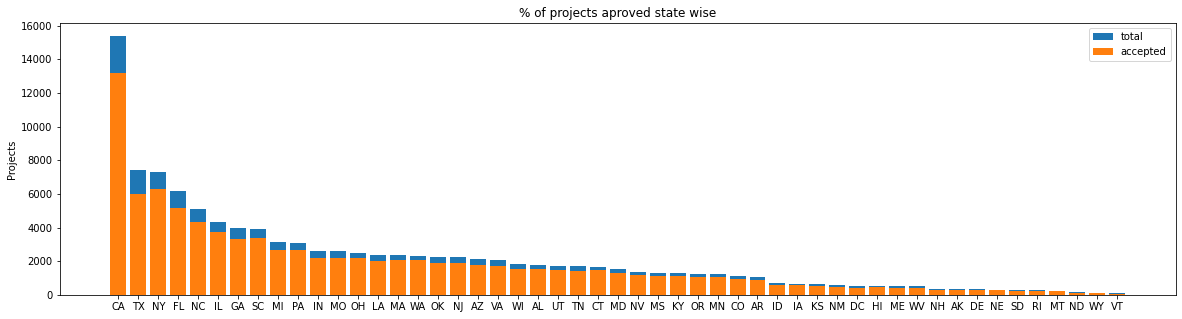

   school_state  project_is_approved  total       Avg
4            CA                13205  15388  0.858136
43           TX                 6014   7396  0.813142
34           NY                 6291   7318  0.859661
9            FL                 5144   6185  0.831690
27           NC                 4353   5091  0.855038
   school_state  project_is_approved  total       Avg
39           RI                  243    285  0.852632
26           MT                  200    245  0.816327
28           ND                  127    143  0.888112
50           WY                   82     98  0.836735
46           VT                   64     80  0.800000


In [20]:
univariate_barplots(project_data, 'school_state', 'project_is_approved', False)

__Every state is having more than 80% success rate in approval__

### 1.2.2 Univariate Analysis: teacher_prefix

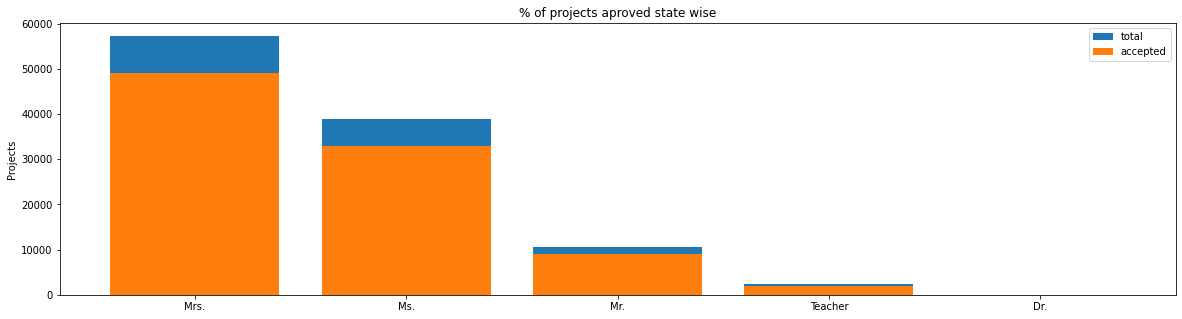

  teacher_prefix  project_is_approved  total       Avg
2           Mrs.                48997  57269  0.855559
3            Ms.                32860  38955  0.843537
1            Mr.                 8960  10648  0.841473
4        Teacher                 1877   2360  0.795339
0            Dr.                    9     13  0.692308
  teacher_prefix  project_is_approved  total       Avg
2           Mrs.                48997  57269  0.855559
3            Ms.                32860  38955  0.843537
1            Mr.                 8960  10648  0.841473
4        Teacher                 1877   2360  0.795339
0            Dr.                    9     13  0.692308


In [21]:
univariate_barplots(project_data, 'teacher_prefix', 'project_is_approved' , top=False)

### 1.2.3 Univariate Analysis: project_grade_category

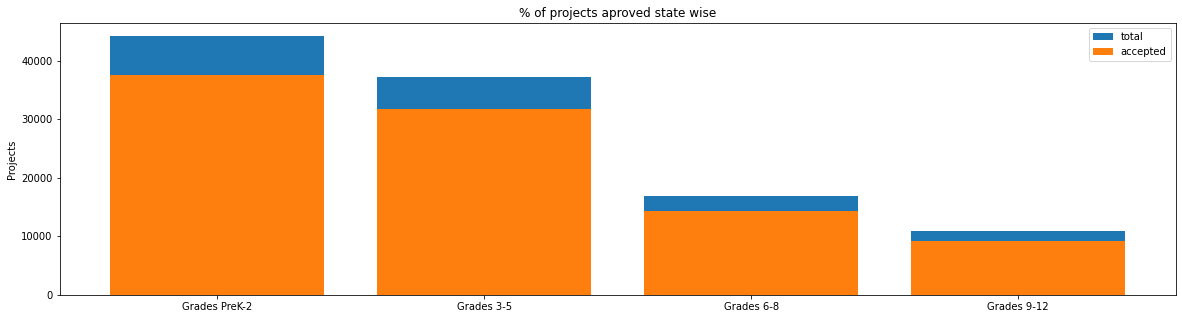

  project_grade_category  project_is_approved  total       Avg
3          Grades PreK-2                37536  44225  0.848751
0             Grades 3-5                31729  37137  0.854377
1             Grades 6-8                14258  16923  0.842522
2            Grades 9-12                 9183  10963  0.837636
  project_grade_category  project_is_approved  total       Avg
3          Grades PreK-2                37536  44225  0.848751
0             Grades 3-5                31729  37137  0.854377
1             Grades 6-8                14258  16923  0.842522
2            Grades 9-12                 9183  10963  0.837636


In [22]:
univariate_barplots(project_data, 'project_grade_category', 'project_is_approved', top=False)

In [23]:
print(list(project_data['project_subject_categories']))

['Literacy & Language', 'History & Civics, Health & Sports', 'Health & Sports', 'Literacy & Language, Math & Science', 'Math & Science', 'Literacy & Language, Special Needs', 'Literacy & Language, Special Needs', 'Math & Science', 'Health & Sports', 'Literacy & Language', 'Literacy & Language', 'Literacy & Language, Applied Learning', 'Math & Science', 'Special Needs', 'Literacy & Language', 'Health & Sports', 'Literacy & Language, Special Needs', 'Math & Science, Literacy & Language', 'Applied Learning', 'Health & Sports', 'Literacy & Language', 'Math & Science, Special Needs', 'Literacy & Language', 'Music & The Arts', 'Math & Science', 'Math & Science', 'Literacy & Language, Math & Science', 'Literacy & Language, Math & Science', 'Literacy & Language, Special Needs', 'Literacy & Language, Applied Learning', 'Literacy & Language', 'Special Needs', 'Math & Science, Literacy & Language', 'History & Civics', 'Literacy & Language', 'Health & Sports', 'Literacy & Language, Math & Science'

In [24]:
catagory_list = ['Literacy & Language', 'The History', 'Health & Sports', 'Literacy & Language, Special Needs']
cat_list = []
for i in catagory_list:
  temp = ''
  for j in i.split(','):
    if 'The' in j.split():
      j=j.replace('The','')
      print("j:",j)
    j = j.replace(' ','')
    temp = temp + j.strip()+" "
    temp = temp.replace('&','_')
    print(temp)
  cat_list.append(temp.strip())


Literacy_Language 
j:  History
History 
Health_Sports 
Literacy_Language 
Literacy_Language SpecialNeeds 


In [25]:
print(cat_list)

['Literacy_Language', 'History', 'Health_Sports', 'Literacy_Language SpecialNeeds']


In [26]:
catogories = list(project_data['project_subject_categories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
cat_list = []
for i in catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') # we are replacing the & value into 
    cat_list.append(temp.strip())

In [27]:
project_data['clean_categories'] = cat_list
project_data.drop(['project_subject_categories'], axis=1, inplace=True)
project_data.head(2)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,Grades PreK-2,"ESL, Literacy",Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0,Literacy_Language
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,2016-10-25 09:22:10,Grades 6-8,"Civics & Government, Team Sports",Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1,History_Civics Health_Sports


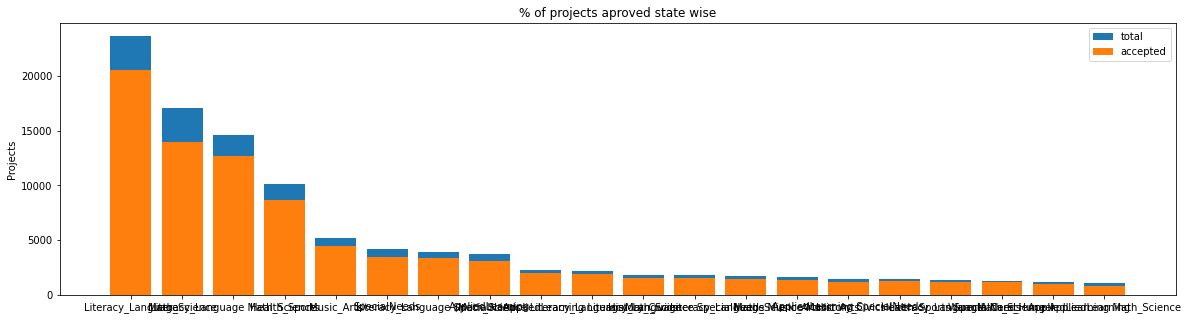

                  clean_categories  project_is_approved  total       Avg
24               Literacy_Language                20520  23655  0.867470
32                    Math_Science                13991  17072  0.819529
28  Literacy_Language Math_Science                12725  14636  0.869432
8                    Health_Sports                 8640  10177  0.848973
40                      Music_Arts                 4429   5180  0.855019
                    clean_categories  project_is_approved  total       Avg
19  History_Civics Literacy_Language                 1271   1421  0.894441
14        Health_Sports SpecialNeeds                 1215   1391  0.873472
50                Warmth Care_Hunger                 1212   1309  0.925898
33      Math_Science AppliedLearning                 1019   1220  0.835246
4       AppliedLearning Math_Science                  855   1052  0.812738


In [28]:
univariate_barplots(project_data, 'clean_categories', 'project_is_approved', top=20)

In [29]:
# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
from collections import Counter
my_counter = Counter()
for word in project_data['clean_categories'].values:
    my_counter.update(word.split())

In [30]:
print(my_counter)

Counter({'Literacy_Language': 52239, 'Math_Science': 41421, 'Health_Sports': 14223, 'SpecialNeeds': 13642, 'AppliedLearning': 12135, 'Music_Arts': 10293, 'History_Civics': 5914, 'Warmth': 1388, 'Care_Hunger': 1388})


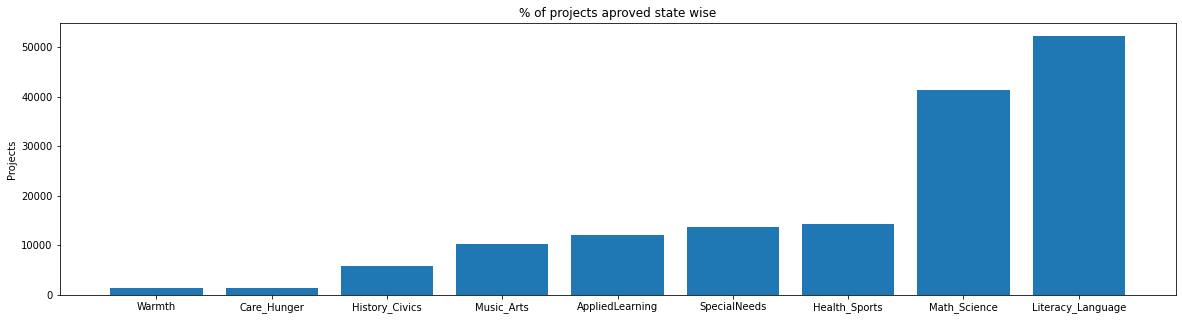

In [31]:
cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))


ind = np.arange(len(sorted_cat_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(sorted_cat_dict.values()))

plt.ylabel('Projects')
plt.title('% of projects aproved state wise')
plt.xticks(ind, list(sorted_cat_dict.keys()))
plt.show()

In [32]:
for i,j in sorted_cat_dict.items():
  print(i, ":", j)

Warmth : 1388
Care_Hunger : 1388
History_Civics : 5914
Music_Arts : 10293
AppliedLearning : 12135
SpecialNeeds : 13642
Health_Sports : 14223
Math_Science : 41421
Literacy_Language : 52239


In [33]:
for i, j in sorted_cat_dict.items():
    print("{:20} :{:10}".format(i,j))

Warmth               :      1388
Care_Hunger          :      1388
History_Civics       :      5914
Music_Arts           :     10293
AppliedLearning      :     12135
SpecialNeeds         :     13642
Health_Sports        :     14223
Math_Science         :     41421
Literacy_Language    :     52239


### 1.2.5 Univariate Analysis: project_subject_subcategories

In [34]:
sub_catogories= list(project_data['project_subject_subcategories'].values)

In [35]:
sub_cat_list = []
for i in sub_catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

In [36]:
project_data['clean_subcategories'] = sub_cat_list
project_data.drop(['project_subject_subcategories'], axis=1, inplace=True)
project_data.head(2)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,Grades PreK-2,Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0,Literacy_Language,ESL Literacy
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,2016-10-25 09:22:10,Grades 6-8,Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1,History_Civics Health_Sports,Civics_Government TeamSports


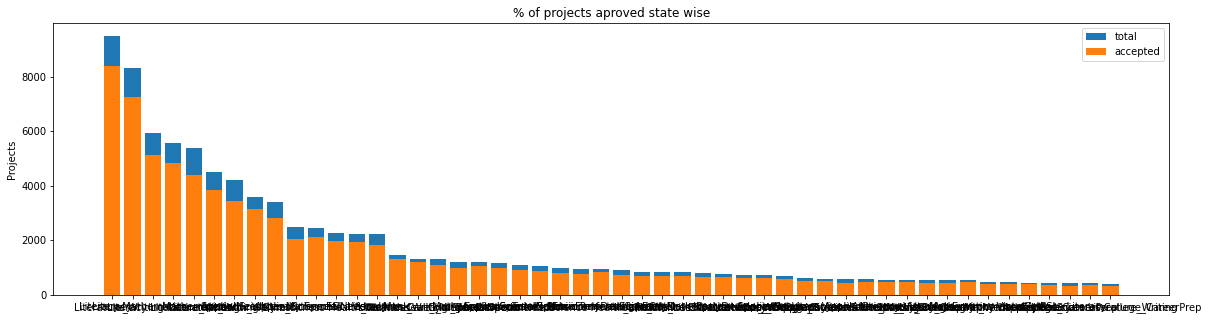

                clean_subcategories  project_is_approved  total       Avg
317                        Literacy                 8371   9486  0.882458
319            Literacy Mathematics                 7260   8325  0.872072
331  Literature_Writing Mathematics                 5140   5923  0.867803
318     Literacy Literature_Writing                 4823   5571  0.865733
342                     Mathematics                 4385   5379  0.815207
                    clean_subcategories  project_is_approved  total       Avg
196       EnvironmentalScience Literacy                  389    444  0.876126
127                                 ESL                  349    421  0.828979
79                   College_CareerPrep                  343    421  0.814727
17   AppliedSciences Literature_Writing                  361    420  0.859524
3    AppliedSciences College_CareerPrep                  330    405  0.814815


In [37]:
univariate_barplots(project_data, 'clean_subcategories', 'project_is_approved', top=50)

In [38]:
# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
from collections import Counter
my_counter = Counter()
for word in project_data['clean_subcategories'].values:
    my_counter.update(word.split())

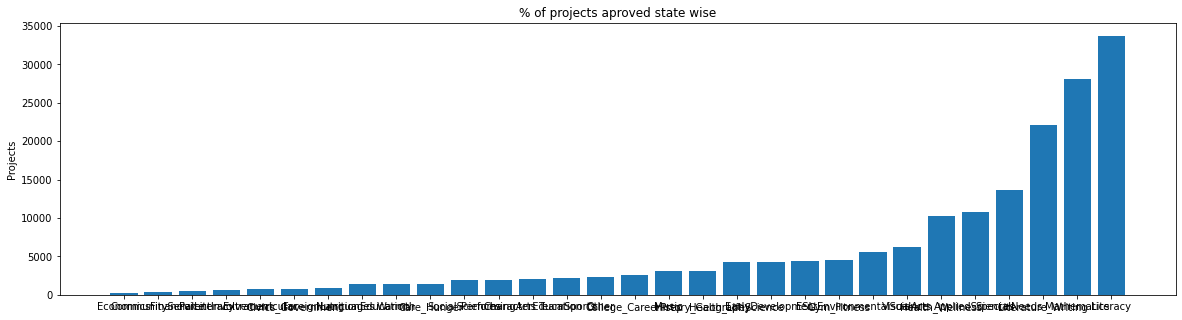

In [39]:
# dict sort by value python: https://stackoverflow.com/a/613218/4084039
sub_cat_dict = dict(my_counter)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1]))


ind = np.arange(len(sorted_sub_cat_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(sorted_sub_cat_dict.values()))

plt.ylabel('Projects')
plt.title('% of projects aproved state wise')
plt.xticks(ind, list(sorted_sub_cat_dict.keys()))
plt.show()

In [40]:
for i, j in sorted_sub_cat_dict.items():
    print("{:20} :{:10}".format(i,j))

Economics            :       269
CommunityService     :       441
FinancialLiteracy    :       568
ParentInvolvement    :       677
Extracurricular      :       810
Civics_Government    :       815
ForeignLanguages     :       890
NutritionEducation   :      1355
Warmth               :      1388
Care_Hunger          :      1388
SocialSciences       :      1920
PerformingArts       :      1961
CharacterEducation   :      2065
TeamSports           :      2192
Other                :      2372
College_CareerPrep   :      2568
Music                :      3145
History_Geography    :      3171
Health_LifeScience   :      4235
EarlyDevelopment     :      4254
ESL                  :      4367
Gym_Fitness          :      4509
EnvironmentalScience :      5591
VisualArts           :      6278
Health_Wellness      :     10234
AppliedSciences      :     10816
SpecialNeeds         :     13642
Literature_Writing   :     22179
Mathematics          :     28074
Literacy             :     33700


### 1.2.6 Univariate Analysis: Text features (Title)

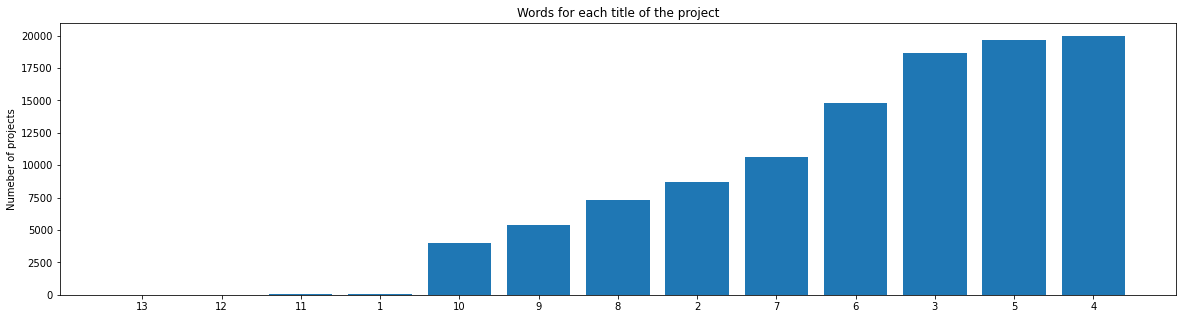

In [41]:
#How to calculate number of words in a string in DataFrame: https://stackoverflow.com/a/37483537/4084039
word_count = project_data['project_title'].str.split().apply(len).value_counts()
word_dict = dict(word_count)
word_dict = dict(sorted(word_dict.items(), key=lambda kv: kv[1]))


ind = np.arange(len(word_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(word_dict.values()))

plt.ylabel('Numeber of projects')
plt.title('Words for each title of the project')
plt.xticks(ind, list(word_dict.keys()))
plt.show()

In [42]:
approved_word_count = project_data[project_data['project_is_approved']==1]['project_title'].str.split().apply(len)
approved_word_count = approved_word_count.values

rejected_word_count = project_data[project_data['project_is_approved']==0]['project_title'].str.split().apply(len)
rejected_word_count = rejected_word_count.values

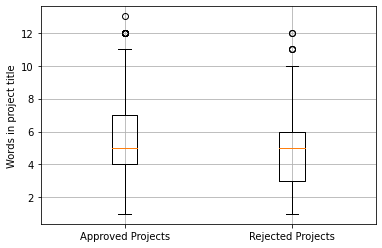

In [43]:
# https://glowingpython.blogspot.com/2012/09/boxplot-with-matplotlib.html
plt.boxplot([approved_word_count, rejected_word_count])
plt.xticks([1,2],('Approved Projects','Rejected Projects'))
plt.ylabel('Words in project title')
plt.grid()
plt.show()

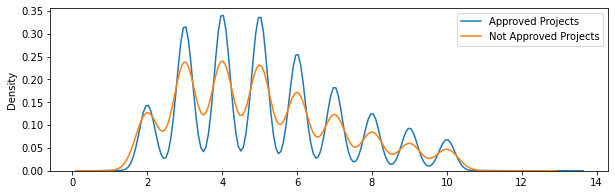

In [44]:
plt.figure(figsize=(10,3))
sns.distplot(approved_word_count, hist=False, label="Approved Projects")
sns.distplot(rejected_word_count, hist=False, label="Not Approved Projects")
plt.legend()
plt.show()

### 1.2.7 Univariate Analysis: Text features (Project Essay's)

In [45]:
# merge two column text dataframe: 
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)

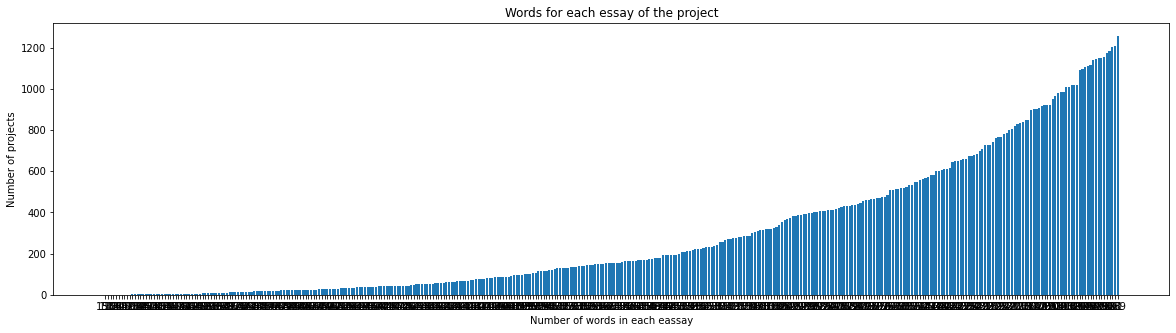

In [46]:
word_count = project_data['essay'].str.split().apply(len).value_counts()
word_dict = dict(word_count)
word_dict = dict(sorted(word_dict.items(), key=lambda kv: kv[1]))


ind = np.arange(len(word_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(word_dict.values()))

plt.ylabel('Number of projects')
plt.xlabel('Number of words in each eassay')
plt.title('Words for each essay of the project')
plt.xticks(ind, list(word_dict.keys()))
plt.show()

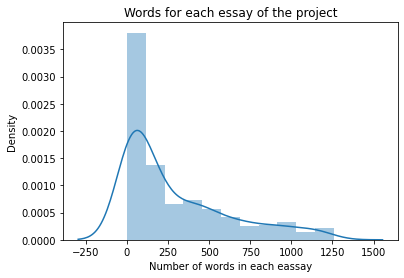

In [47]:
sns.distplot(word_count.values)
plt.title('Words for each essay of the project')
plt.xlabel('Number of words in each eassay')
plt.show()


In [48]:
approved_word_count = project_data[project_data['project_is_approved']==1]['essay'].str.split().apply(len)
approved_word_count = approved_word_count.values

rejected_word_count = project_data[project_data['project_is_approved']==0]['essay'].str.split().apply(len)
rejected_word_count = rejected_word_count.values

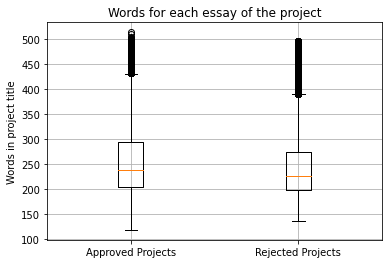

In [49]:
# https://glowingpython.blogspot.com/2012/09/boxplot-with-matplotlib.html
plt.boxplot([approved_word_count, rejected_word_count])
plt.title('Words for each essay of the project')
plt.xticks([1,2],('Approved Projects','Rejected Projects'))
plt.ylabel('Words in project title')
plt.grid()
plt.show()

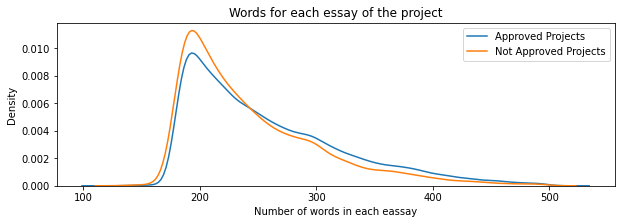

In [50]:
plt.figure(figsize=(10,3))
sns.distplot(approved_word_count, hist=False, label="Approved Projects")
sns.distplot(rejected_word_count, hist=False, label="Not Approved Projects")
plt.title('Words for each essay of the project')
plt.xlabel('Number of words in each eassay')
plt.legend()
plt.show()

### 1.2.8 Univariate Analysis: Cost per project

In [51]:
resource_data.head(1)

,id,description,quantity,price
0,p233245,LC652 - Lakeshore Double-Space Mobile Drying Rack,1,149.0


In [52]:
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
price_data.head(1)

,id,price,quantity
0,p000001,459.56,7


In [53]:
# merge two data frame 
project_data = pd.merge(project_data, price_data, on='id', how='left')
project_data.head(2)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price,quantity
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,Grades PreK-2,Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0,Literacy_Language,ESL Literacy,My students are English learners that are work...,154.6,23
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,2016-10-25 09:22:10,Grades 6-8,Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1,History_Civics Health_Sports,Civics_Government TeamSports,Our students arrive to our school eager to lea...,299.0,1


In [54]:
approved_price = project_data[project_data['project_is_approved']==1]['price'].values

In [55]:
rejected_price = project_data[project_data['project_is_approved']==0]['price'].values

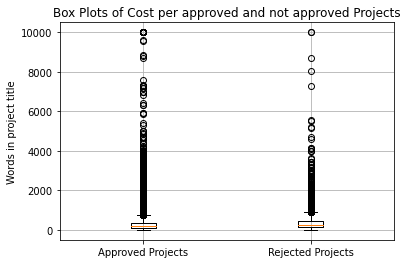

In [56]:
# https://glowingpython.blogspot.com/2012/09/boxplot-with-matplotlib.html
plt.boxplot([approved_price, rejected_price])
plt.title('Box Plots of Cost per approved and not approved Projects')
plt.xticks([1,2],('Approved Projects','Rejected Projects'))
plt.ylabel('Words in project title')
plt.grid()
plt.show()

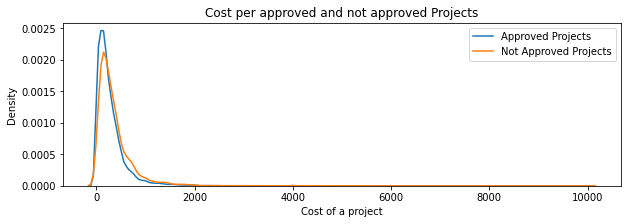

In [57]:
plt.figure(figsize=(10,3))
sns.distplot(approved_price, hist=False, label="Approved Projects")
sns.distplot(rejected_price, hist=False, label="Not Approved Projects")
plt.title('Cost per approved and not approved Projects')
plt.xlabel('Cost of a project')
plt.legend()
plt.show()

In [58]:
from prettytable import PrettyTable

x = PrettyTable()
x.field_names = ["Percentile", "Approved Projects", "Not Approved Projects"]

for i in range(0,101,5):
    x.add_row([i,np.round(np.percentile(approved_price,i), 3), np.round(np.percentile(rejected_price,i), 3)])
print(x)

+------------+-------------------+-----------------------+
| Percentile | Approved Projects | Not Approved Projects |
+------------+-------------------+-----------------------+
|     0      |        0.66       |          1.97         |
|     5      |       13.59       |          41.9         |
|     10     |       33.88       |         73.67         |
|     15     |        58.0       |         99.109        |
|     20     |       77.38       |         118.56        |
|     25     |       99.95       |        140.892        |
|     30     |       116.68      |         162.23        |
|     35     |      137.232      |        184.014        |
|     40     |       157.0       |        208.632        |
|     45     |      178.265      |        235.106        |
|     50     |       198.99      |        263.145        |
|     55     |       223.99      |         292.61        |
|     60     |       255.63      |        325.144        |
|     65     |      285.412      |         362.39       

<h3><font color='red'>1.2.9 Univariate Analysis: teacher_number_of_previously_posted_projects</font></h3>

In [59]:
project_data['teacher_number_of_previously_posted_projects'].value_counts()

0      30014
1      16058
2      10350
3       7110
4       5266
       ...  
296        1
329        1
359        1
422        1
235        1
Name: teacher_number_of_previously_posted_projects, Length: 374, dtype: int64

In [60]:
approved_projects = project_data[project_data['project_is_approved']==1]['teacher_number_of_previously_posted_projects'].value_counts()
approved_projects = list(approved_projects)

In [61]:
rejected_projects = project_data[project_data['project_is_approved']==0]['teacher_number_of_previously_posted_projects'].value_counts()
rejected_projects = list(rejected_projects)

In [62]:
print(approved_projects + rejected_projects)

[24652, 13329, 8705, 5997, 4452, 3536, 2911, 2298, 1977, 1700, 1419, 1258, 1163, 1040, 871, 818, 769, 712, 666, 632, 578, 519, 495, 479, 456, 405, 378, 352, 336, 313, 301, 296, 279, 277, 276, 243, 231, 224, 202, 196, 195, 167, 162, 149, 149, 145, 141, 135, 129, 128, 127, 123, 122, 117, 110, 109, 109, 108, 100, 98, 93, 92, 91, 89, 88, 84, 80, 74, 72, 69, 68, 67, 60, 60, 59, 58, 58, 58, 57, 55, 54, 53, 51, 47, 46, 46, 44, 43, 43, 42, 42, 42, 41, 39, 39, 39, 38, 38, 37, 37, 37, 36, 36, 36, 34, 33, 33, 33, 32, 31, 31, 31, 31, 31, 30, 29, 28, 27, 27, 27, 26, 25, 24, 24, 23, 23, 23, 22, 21, 21, 19, 19, 19, 18, 18, 17, 17, 17, 17, 16, 16, 15, 15, 15, 15, 15, 15, 14, 14, 14, 14, 14, 13, 13, 13, 13, 13, 13, 12, 12, 12, 12, 12, 12, 11, 11, 11, 11, 11, 11, 10, 10, 10, 10, 10, 9, 9, 9, 9, 9, 9, 9, 9, 8, 8, 8, 8, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

[373, 180]


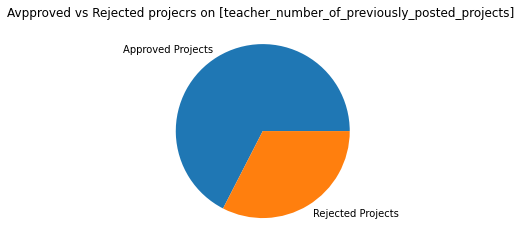

In [63]:
project_status = [len(approved_projects)] + [len(rejected_projects)]
print(project_status)

labels = ["Approved Projects","Rejected Projects"]
plt.title("Avpproved vs Rejected projecrs on [teacher_number_of_previously_posted_projects] ")
plt.pie(project_status, labels=labels)
plt.show() 


In [64]:
x = PrettyTable()
x.field_names = ["Approved Projects", "Not Approved Projects"]

for i in range(0,1):
    x.add_row([len(approved_projects),len(rejected_projects)])
print(x)

+-------------------+-----------------------+
| Approved Projects | Not Approved Projects |
+-------------------+-----------------------+
|        373        |          180          |
+-------------------+-----------------------+


<h3><font color='red'>1.2.10 Univariate Analysis: 

---

project_resource_summary</font></h3>

In [65]:
project_resource_summary = project_data['project_resource_summary']

import re
digit_in_summary = []
for i in project_resource_summary:
  if re.search(r'\d', i):
    digit_in_summary.append(1)
  else:
    digit_in_summary.append(0)

In [66]:
#print(digit_in_summary)

In [67]:
# Using 'Address' as the column name and equating it to the list 
project_data = project_data.assign(digit_in_summary = digit_in_summary) 

In [68]:
project_data.head(1)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price,quantity,digit_in_summary
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,Grades PreK-2,Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0,Literacy_Language,ESL Literacy,My students are English learners that are work...,154.6,23,0


In [69]:
# analyze presence of digit effects the project acceptence or not 

In [70]:
# project accepted with digit 1
project_accepted_with_digit = project_data.loc[(project_data['project_is_approved']==1 ) & (project_data['digit_in_summary'] == 1)]
# project accepted with digit 0 
project_accepted_with_no_digit = project_data.loc[(project_data['project_is_approved']==1 ) & (project_data['digit_in_summary'] == 0)]

# project not accepted with digit 1
project_not_accepted_with_digit = project_data.loc[(project_data['project_is_approved']==0 ) & (project_data['digit_in_summary'] == 1)]

# project not accepted with digit 0 
project_not_accepted_with_no_digit = project_data.loc[(project_data['project_is_approved']==0 ) & (project_data['digit_in_summary'] == 0)]


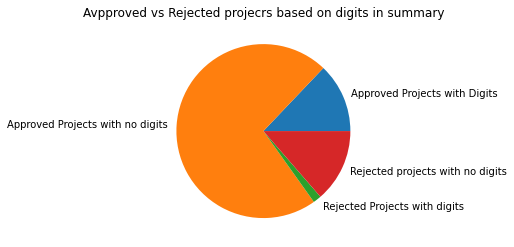

In [71]:
labels = ["Approved Projects with Digits","Approved Projects with no digits", "Rejected Projects with digits", "Rejected projects with no digits"]
plt.title("Avpproved vs Rejected projecrs based on digits in summary")
pie_data = [len(project_accepted_with_digit), len(project_accepted_with_no_digit), len(project_not_accepted_with_digit), len(project_not_accepted_with_no_digit) ]
plt.pie(pie_data, labels=labels)
plt.show() 


__Approved projects with no digits have higher chance of approval__

In [72]:
x = PrettyTable()
x.field_names = ["Approved Projects with Digits","Approved Projects with no digits", "Rejected Projects with digits", "Rejected projects with no digits"]

for i in range(0,1):
    x.add_row([len(project_accepted_with_digit),len(project_accepted_with_no_digit),len(project_not_accepted_with_digit),len(project_not_accepted_with_no_digit)])
print(x)



+-------------------------------+----------------------------------+-------------------------------+----------------------------------+
| Approved Projects with Digits | Approved Projects with no digits | Rejected Projects with digits | Rejected projects with no digits |
+-------------------------------+----------------------------------+-------------------------------+----------------------------------+
|             14090             |              78616               |              1666             |              14876               |
+-------------------------------+----------------------------------+-------------------------------+----------------------------------+


# 2. Preprocessing Categorical Features: project_grade_category

In [73]:
project_data = pd.read_csv("/content/drive/MyDrive/collab_data/donorchoose/train_data.csv", nrows=5000)
resource_data = pd.read_csv("/content/drive/MyDrive/collab_data/donorchoose/resources.csv")

In [74]:
print("Number of data points in train data", project_data.shape)
print('-'*50)
print("The attributes of data :", project_data.columns.values)

Number of data points in train data (5000, 17)
--------------------------------------------------
The attributes of data : ['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']


In [75]:
project_data['project_grade_category'].value_counts()

Grades PreK-2    2002
Grades 3-5       1729
Grades 6-8        785
Grades 9-12       484
Name: project_grade_category, dtype: int64

In [76]:
project_data['project_grade_category'].head(2)

0    Grades PreK-2
1       Grades 6-8
Name: project_grade_category, dtype: object

we need to remove the spaces, replace the '-' with '_' and convert all the letters to small



In [77]:
project_data['project_grade_category'] = project_data['project_grade_category'].str.replace(' ','_')
project_data['project_grade_category'] = project_data['project_grade_category'].str.replace('-','_')
project_data['project_grade_category'] = project_data['project_grade_category'].str.lower()
project_data['project_grade_category'].value_counts()

grades_prek_2    2002
grades_3_5       1729
grades_6_8        785
grades_9_12       484
Name: project_grade_category, dtype: int64

# 3. Preprocessing Categorical Features: project_subject_categories

In [78]:
project_data['project_subject_categories'].value_counts()

Literacy & Language                           1067
Math & Science                                 795
Literacy & Language, Math & Science            679
Health & Sports                                509
Music & The Arts                               233
Literacy & Language, Special Needs             207
Applied Learning                               164
Special Needs                                  162
Math & Science, Literacy & Language            101
Applied Learning, Literacy & Language           97
Applied Learning, Special Needs                 80
Math & Science, Special Needs                   80
Literacy & Language, Music & The Arts           79
Math & Science, Music & The Arts                76
History & Civics, Literacy & Language           65
History & Civics                                63
Health & Sports, Special Needs                  57
Warmth, Care & Hunger                           53
Math & Science, Applied Learning                52
Applied Learning, Math & Scienc

we need to remove:  the & "," and convert into lower case

In [79]:
project_data['project_subject_categories'] = project_data['project_subject_categories'].str.replace('The', '')
project_data['project_subject_categories'] = project_data['project_subject_categories'].str.replace('&', '_')
project_data['project_subject_categories'] = project_data['project_subject_categories'].str.replace(',','_')
project_data['project_subject_categories'] = project_data['project_subject_categories'].str.replace(' ', '')
project_data['project_subject_categories'] = project_data['project_subject_categories'].str.lower()

project_data['project_subject_categories'].value_counts()

literacy_language                       1067
math_science                             795
literacy_language_math_science           679
health_sports                            509
music_arts                               233
literacy_language_specialneeds           207
appliedlearning                          164
specialneeds                             162
math_science_literacy_language           101
appliedlearning_literacy_language         97
math_science_specialneeds                 80
appliedlearning_specialneeds              80
literacy_language_music_arts              79
math_science_music_arts                   76
history_civics_literacy_language          65
history_civics                            63
health_sports_specialneeds                57
warmth_care_hunger                        53
math_science_appliedlearning              52
appliedlearning_math_science              44
health_sports_literacy_language           40
literacy_language_history_civics          40
appliedlea

# 4. Preprocessing Categorical Features: teacher_prefix


In [80]:
project_data['teacher_prefix'].value_counts()

Mrs.       2560
Ms.        1845
Mr.         495
Teacher     100
Name: teacher_prefix, dtype: int64

Large number of Mrs teacher prefix

In [81]:
# checking of nan values
project_data['teacher_prefix'].isnull().values.any()

False

No nan values. But for safe side, we can fill the if any missing values with Mrs. as Mrs is maximum dominating category

In [82]:
project_data['teacher_prefix'] = project_data['teacher_prefix'].fillna('Mrs.')

In [83]:
project_data['teacher_prefix'].value_counts()

Mrs.       2560
Ms.        1845
Mr.         495
Teacher     100
Name: teacher_prefix, dtype: int64

remove '.' and convert all into smallcase

In [84]:
project_data['teacher_prefix'] = project_data['teacher_prefix'].str.replace('.', '')
project_data['teacher_prefix'] = project_data['teacher_prefix'].str.lower()

project_data['teacher_prefix'].value_counts()

mrs        2560
ms         1845
mr          495
teacher     100
Name: teacher_prefix, dtype: int64

# 5. Preprocessing Categorical Features: project_subject_subcategories

In [85]:
project_data['project_subject_subcategories'].value_counts()

Literacy                                449
Literacy, Mathematics                   368
Literature & Writing, Mathematics       293
Literacy, Literature & Writing          234
Mathematics                             232
                                       ... 
Mathematics, Team Sports                  1
Civics & Government, Extracurricular      1
College & Career Prep, Music              1
Extracurricular, History & Geography      1
Applied Sciences, Foreign Languages       1
Name: project_subject_subcategories, Length: 248, dtype: int64

Remove 'the', and repalce ',' '&' with _ and convert them into small case

In [86]:
project_data['project_subject_subcategories'] = project_data['project_subject_subcategories'].str.replace('The', '')
project_data['project_subject_subcategories'] = project_data['project_subject_subcategories'].str.replace(',', '_')
project_data['project_subject_subcategories'] = project_data['project_subject_subcategories'].str.replace('&', '_')
project_data['project_subject_subcategories'] = project_data['project_subject_subcategories'].str.replace(' ', '')
project_data['project_subject_subcategories'] = project_data['project_subject_subcategories'].str.lower()

project_data['project_subject_subcategories'].value_counts()


literacy                                  449
literacy_mathematics                      368
literature_writing_mathematics            293
literacy_literature_writing               234
mathematics                               232
                                         ... 
environmentalscience_parentinvolvement      1
foreignlanguages_health_lifescience         1
other_parentinvolvement                     1
earlydevelopment_health_lifescience         1
gym_fitness_music                           1
Name: project_subject_subcategories, Length: 248, dtype: int64

# 6. Preprocessing Categorical Features: school_state

In [87]:
project_data['school_state'].value_counts()

CA    707
TX    352
NY    342
FL    261
NC    246
SC    191
IL    184
GA    164
MI    151
PA    151
OH    122
OK    120
MO    117
MA    115
LA    114
IN    113
NJ     99
AZ     99
WA     97
VA     90
TN     85
AL     84
CT     78
UT     76
WI     72
MD     69
OR     64
KY     59
CO     58
NV     53
AR     52
MN     48
MS     46
KS     30
IA     29
ID     29
HI     28
DC     23
NM     22
WV     21
ME     19
NE     19
AK     17
RI     16
SD     16
NH     13
ND     11
DE     11
WY      9
MT      6
VT      2
Name: school_state, dtype: int64

convert all into smallcase

In [88]:
project_data['school_state'] = project_data['school_state'].str.lower()
project_data['school_state'].value_counts()

ca    707
tx    352
ny    342
fl    261
nc    246
sc    191
il    184
ga    164
pa    151
mi    151
oh    122
ok    120
mo    117
ma    115
la    114
in    113
az     99
nj     99
wa     97
va     90
tn     85
al     84
ct     78
ut     76
wi     72
md     69
or     64
ky     59
co     58
nv     53
ar     52
mn     48
ms     46
ks     30
id     29
ia     29
hi     28
dc     23
nm     22
wv     21
ne     19
me     19
ak     17
ri     16
sd     16
nh     13
de     11
nd     11
wy      9
mt      6
vt      2
Name: school_state, dtype: int64

# 7. Preprocessing Categorical Features: project_title

In [89]:
project_data['project_title'].value_counts()

Flexible Seating                                       12
We Like to Move It, Move It!                            7
Wiggle While We Work                                    5
Flexible Seating!                                       4
We Need to Move It, Move It!                            4
                                                       ..
Flexible Classroom Seating & Storage Organization       1
Healthy Snacks to Teach Healthy Eating                  1
Gardening Supplies For Greener Thumbs                   1
Noise Limiting Headphones To Promote Concentration!     1
Modeling for Multiple Learning Styles                   1
Name: project_title, Length: 4932, dtype: int64

Remove '!', 

In [90]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [91]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [92]:
project_data['project_title'].head(5)

0     Educational Support for English Learners at Home
1                Wanted: Projector for Hungry Learners
2    Soccer Equipment for AWESOME Middle School Stu...
3                               Techie Kindergarteners
4                               Interactive Math Tools
Name: project_title, dtype: object

printing random row data below

In [93]:
print(9, project_data['project_title'].values[9])
print("-"*80)
print(12, project_data['project_title'].values[12])

9 Just For the Love of Reading--\r\nPure Pleasure
--------------------------------------------------------------------------------
12 Building Life Science Experiences


In [94]:
# Combining all the above steps 
from tqdm import tqdm
def preprocess_text(text_data):
    preprocessed_text = []
    # tqdm is for printing the status bar
    for sentance in tqdm(text_data):
        sent = decontracted(sentance)
        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\n', ' ')
        sent = sent.replace('\\"', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        # https://gist.github.com/sebleier/554280
        sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
        preprocessed_text.append(sent.lower().strip())
    return preprocessed_text

In [95]:
preprocessed_titles = preprocess_text(project_data['project_title'].values)

100%|██████████| 5000/5000 [00:00<00:00, 39649.03it/s]


In [96]:
print(9, preprocessed_titles[9])
print("-"*80)
print(12, preprocessed_titles[12])

9 love reading pure pleasure
--------------------------------------------------------------------------------
12 building life science experiences


# 8. Preprocessing Categorical Features: essay

In [97]:
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)
                        
project_data['essay'].value_counts()

My students are my babies...I want the world for them!\r\nI teach three and four-year-old students with disabilities in the inner city. My students have a range of disabilities including autism, physical handicaps, and developmental delays. 99% of the student population receive free or reduced-price breakfast and lunch. My students are inquisitive, energetic, and most importantly full of questions. They are future nurses, doctors, scientists, police, and leaders. I believe in every one of my students' future and want to provide a solid and supportive start to their education.Having this computer in the classroom would provide endless opportunities for learning, exposure, and fun. Many of my students have language impairments due to lack of exposures/ life experiences. I would use this computer daily to provide visual support when teaching language and academic concepts. This computer would be able to be used in the whole group instruction to support my teaching. I could show students e

In [98]:
print("printing some random essay")
print(9, project_data['essay'].values[9])
print('-'*50)
print(34, project_data['essay'].values[34])
print('-'*50)
print(147, project_data['essay'].values[147])

printing some random essay
9 Over 95% of my students are on free or reduced lunch.  I have a few who are homeless, but despite that, they come to school with an eagerness to learn.  My students are inquisitive eager learners who  embrace the challenge of not having great books and other resources  every day.  Many of them are not afforded the opportunity to engage with these big colorful pages of a book on a regular basis at home and they don't travel to the public library.  \r\nIt is my duty as a teacher to do all I can to provide each student an opportunity to succeed in every aspect of life. \r\nReading is Fundamental! My students will read these books over and over again while boosting their comprehension skills. These books will be used for read alouds, partner reading and for Independent reading. \r\nThey will engage in reading to build their \"Love for Reading\" by reading for pure enjoyment. They will be introduced to some new authors as well as some old favorites. I want my st

In [99]:
preprocessed_essays = preprocess_text(project_data['essay'].values)

100%|██████████| 5000/5000 [00:02<00:00, 1712.01it/s]


In [100]:
print("printing some random essay")
print(9, preprocessed_essays[9])
print('-'*50)
print(34, preprocessed_essays[34])
print('-'*50)
print(147, preprocessed_essays[147])

printing some random essay
9 95 students free reduced lunch homeless despite come school eagerness learn students inquisitive eager learners embrace challenge not great books resources every day many not afforded opportunity engage big colorful pages book regular basis home not travel public library duty teacher provide student opportunity succeed every aspect life reading fundamental students read books boosting comprehension skills books used read alouds partner reading independent reading engage reading build love reading reading pure enjoyment introduced new authors well old favorites want students ready 21st century know pleasure holding good hard back book hand nothing like good book read students soar reading consideration generous funding contribution help build stamina prepare 3rd grade thank much reading proposal nannan
--------------------------------------------------
34 students mainly come extremely low income families majority come homes parents work full time students s

# 8. Preprocessing Numerical Values: price

In [101]:
resource_data.head(1)

,id,description,quantity,price
0,p233245,LC652 - Lakeshore Double-Space Mobile Drying Rack,1,149.0


In [102]:
resource_data.loc[(resource_data['quantity']==2)] 

,id,description,quantity,price
3,p069063,"Dixon Ticonderoga Wood-Cased #2 HB Pencils, Bo...",2,13.59
7,p069063,"See-N-Read 1503905CQ Reading Tool - Book Size,...",2,10.11
8,p096795,"Brewster WPD90218 Wall Pops Flirt Dot, Set of ...",2,9.95
9,p096795,Brewster Wall Pops WPE99065 Peel & Stick Calyp...,2,9.02
14,p236235,PP440X - Fairy Tales Problem Solving STEM Kits,2,149.00
...,...,...,...,...
1541258,p086116,"iPad 9.7 2017 Case (New 2017 Model), EasyAcc U...",2,9.90
1541261,p228679,EE809 - Magnetic Fishing Poles - Set of 2,2,12.99
1541266,p031981,5pcs DC3V/0.1A 1.5V/0.05A 10x2.7mm Coin Mobile...,2,6.46
1541270,p031981,Flormoon DC Motor Mini Electric Motor 0.5-3V 1...,2,8.14


In [103]:
resource_data['id'].value_counts()

p066966    100
p009778    100
p137603    100
p143469     99
p108080     99
          ... 
p079620      1
p139661      1
p191077      1
p227296      1
p202481      1
Name: id, Length: 260115, dtype: int64

same id has many quantity , we need to aggregate them together

In [104]:
price_data = resource_data.groupby('id').agg({'quantity': 'sum', 'price':'sum'}).reset_index()
price_data.head(1)

,id,quantity,price
0,p000001,7,459.56


In [105]:
price_data['id'].value_counts()

p165610    1
p067663    1
p039323    1
p247009    1
p084927    1
          ..
p178783    1
p091662    1
p030931    1
p076250    1
p064537    1
Name: id, Length: 260115, dtype: int64

In [106]:
# join two dataframes in python: 
project_data = pd.merge(project_data, price_data, on='id', how='left')

In [107]:
project_data.head(1)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,essay,quantity,price
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,mrs,in,2016-12-05 13:43:57,grades_prek_2,literacy_language,esl_literacy,Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0,My students are English learners that are work...,23,154.6


## 8.1 applying StandardScaler

In [109]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(project_data['price'].values.reshape(-1, 1))
project_data['std_price']=scaler.transform(project_data['price'].values.reshape(-1, 1) )

In [110]:
project_data['std_price'].head()

0   -0.393708
1   -0.010053
2    0.568751
3   -0.185673
4   -0.623847
Name: std_price, dtype: float64

## 8.2 applying MinMaxScaler

We need to apply 

In [108]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(project_data['price'].values.reshape(-1, 1))
project_data['nrm_price']=scaler.transform(project_data['price'].values.reshape(-1, 1))

In [112]:
project_data['nrm_price'].head()

0    0.015320
1    0.029763
2    0.051554
3    0.023152
4    0.006656
Name: nrm_price, dtype: float64